<div align="center">
<h1 style="color:#1565c0; font-size:2.8em; font-weight:bold; margin-bottom:0.2em; margin-top:0.5em;">Практична робота №2</h1>
<h3 style="color:#1976d2; margin-top:0; font-weight:normal;">Побудова та оцiнювання якостi
моделей класифiкацiї та регресiї засобами бiблiотеки <b>Scikit-Learn Python</b></h3>
<br>
<br>
<b>Варіант 12</b><br>
<b>Автори:</b><br>
Плахтій Злата, КА-32<br>
Пастушенко Максим, КА-33<br>
Романов Фелікс, КА-33
</div>

<b>Мета:</b> Метою роботи є побудова та оцiнювання якостi моделей:
- дерев рiшень,
- опорних векторiв,
- логiстичної регресiї,
- наївної баєсiвської моделi
для класифiкацiї та регресiї засобами бiблiотеки Scikit-Learn Python.

<b>Хід роботи:</b>
1. Підготувати дані.
2. Представити початкових даних графiчно.
3. Розбити данi на навчальний та валiдацiйний набори.
4. Побудувати на навчальному наборi даних моделi класифiкацiї або регресiї заданi згiдно з варiантом.
4. Представити моделi графiчно (наприклад вивести частину дерева рiшень, побудувати лiнiю регресiї тощо).
5. Виконати прогнози на основi побудованих моделей.
6. Для кожної з моделей оцiнити, чи має мiсце перенавчання.
7. В задачах регресiї розрахувати для кожної моделi наступнi критерiї якостi, окремо на навчальнiй та валiдацiйнiй множинах:

    • коефiцiєнт детермiнацiї R2,
    
    • помилки RMSE, MAE та MAPE.

8. Спробувати виконати решiтчастий пошук (grid search) для пiдбору гiперпараметрiв моделей.
9. Зробити висновки про якiсть роботи моделей на дослiджених даних. На
основi критерiїв якостi спробувати обрати найкращу модель.
10. Навчити моделi на пiдмножинах навчальних даних. Оцiнити, наскiльки
розмiр навчальної множини впливає на якiсть моделi.
11. Кожний варiант мiстить два набори даних. Дослiдити обидва набори за
наведеними вище етапами.

<b>Завдання:</b><br>
Побудувати моделi регресiї на основi методу опорних векторiв:<br><br>
• Моделi нелiнiйної регресiї SVR(kernel="poly") з полiномiальним ядром. <br>
  Розглянути полiноми рiзного ступеня degree та рiзнi комбiнацiї гiперпараметрiв epsilon i C, наприклад: epsilon=0.1 i C=0.01; epsilon=0.1 i C=100.<br><br>
• Настроїти гiперпараметри epsilon i C, використовуючи решітчастий пошук.<br><br>
Початковi данi:<br>
(б) [avocado_prices.csv](https://www.kaggle.com/datasets/neuromusic/avocado-prices)
для якогось коміта

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter1d

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# ------------------------------
# 1.1. Завантаження та огляд даних
# ------------------------------

import pandas as pd
import numpy as np

# Load
df = pd.read_csv('data/avocado.csv')
df.columns = df.columns.str.strip()

# Header
print(f"Rows: {df.shape[0]:,}  |  Cols: {df.shape[1]:,}  |  Memory: {df.memory_usage(deep=True).sum()/1024**2:.3f} MB")
print("Columns:", ", ".join(df.columns))

# Types + non-null + unique (compact)
info = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "non_null": df.notna().sum(),
    "unique": df.nunique(dropna=False)
})
print("\nTypes / non-null / unique:")
print(info.to_string())

# Quick peek
print("\nHead:")
print(df.head().to_string(index=False))

# Numeric descriptive (compact)
num = df.select_dtypes(include=[np.number])
if not num.empty:
    print("\nNumeric summary:")
    print(num.describe().T.loc[:, ["count","mean","std","min","50%","max"]].to_string(float_format="{:,.3f}".format))

# Duplicates
dups = df.duplicated().sum()
print(f"\nDuplicate rows: {dups}")
if dups:
    print("  First duplicates:")
    print(df[df.duplicated(keep='first')].head(3).to_string(index=False))

# Date parsing
if 'Date' in df.columns:
    parsed = pd.to_datetime(df['Date'], errors='coerce')
    bad = parsed.isna().sum()
    print(f"\nDate column: original dtype={df['Date'].dtype}, parse_failures={bad}")
    if bad==0:
        print(f"  Date range: {parsed.min().date()} — {parsed.max().date()}")
    else:
        print("  Example unparsable Date values:")
        print(df.loc[parsed.isna(), 'Date'].drop_duplicates().head(5).to_string(index=False))

# Quick numeric sanity checks
neg = [(c,int((df[c]<0).sum())) for c in num.columns if (df[c]<0).any()]
if neg:
    print("\nNegative values found:")
    for c,n in neg:
        print(f"  {c}: {n}")
else:
    print("\nNo negative values in numeric columns (quick check).")



Стовпці датасету:
['Unnamed: 0', 'Date', 'AveragePrice', 'Total Volume', '4046', '4225', '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year', 'region']


Інформація про датасет:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    18249 non-null  int64  
 1   Date          18249 non-null  object 
 2   AveragePrice  18249 non-null  float64
 3   Total Volume  18249 non-null  float64
 4   4046          18249 non-null  float64
 5   4225          18249 non-null  float64
 6   4770          18249 non-null  float64
 7   Total Bags    18249 non-null  float64
 8   Small Bags    18249 non-null  float64
 9   Large Bags    18249 non-null  float64
 10  XLarge Bags   18249 non-null  float64
 11  type          18249 non-null  object 
 12  year          18249 non-null  int64  
 13  region        18249 non-null  objec

In [3]:

# ------------------------------
# 1.2. підготовка даних
# ------------------------------

# Видалити зайві стовпці 
drop_candidates = ['Unnamed: 0', 'Unnamed:0', 'year']
drop_cols = [c for c in drop_candidates if c in df.columns]
if drop_cols:
    df.drop(columns=drop_cols, inplace=True)
    print('\nВидалені службові колонки:', drop_cols)
    
# Конвертувати Date у тип datetime
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    print("\nConverted 'Date' to datetime. Null dates:", df['Date'].isnull().sum())

    # Якщо є пропуски у Date — можна їх видалити (або обробити інакше)
    if df['Date'].isnull().any():
        n_dt = df['Date'].isnull().sum()
        df = df[~df['Date'].isnull()]
        print(f"Dropped {n_dt} rows with invalid Date.")

    # --- Додаткові похідні ознаки від Date ---
    # рік, місяць, тиждень, день тижня
    df['year'] = df['Date'].dt.year
    # місяць як ціле (1-12)
    df['month'] = df['Date'].dt.month
    # тиждень ISO (pandas >= 1.1 повертає isocalendar DataFrame)
    try:
        df['week'] = df['Date'].dt.isocalendar().week.astype(int)
    except Exception:
        # сумісність зі старішими pandas
        df['week'] = df['Date'].dt.week.astype(int)
    df['dayofweek'] = df['Date'].dt.dayofweek  # 0 = Monday

    # циклічне кодування місяця (рекомендовано для сезонності)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    # ------------------------------------------

# Перейменувати колонки 4046, 4225, 4770
rename_map = {}
for c in ['4046', '4225', '4770']:
    if c in df.columns:
        rename_map[c] = f'PLU_{c}'
if rename_map:
    df = df.rename(columns=rename_map)
    print("\nRenamed columns:", rename_map)

# Очищення даних – перевірити та обробити пропуски, видалити дублікати
print("\nMissing values (before):\n", df.isnull().sum())

# Видалити повні дублікатні рядки
dup_count = df.duplicated().sum()
if dup_count:
    df = df.drop_duplicates()
print(f"\nRemoved {dup_count} duplicate rows (if any).")

# Обробка пропусків:
# - Якщо пропуск у цільовій змінній 'AveragePrice' — видаляємо такі записи
if 'AveragePrice' in df.columns:
    before = len(df)
    df = df[~df['AveragePrice'].isnull()]
    print(f"\nDropped {before - len(df)} rows with null AveragePrice.")

# - Категоріальні: якщо пропуски у 'type' або 'region' — видаляти 
for cat in ['type', 'region']:
    if cat in df.columns:
        n_missing = df[cat].isnull().sum()
        if n_missing:
            df = df[~df[cat].isnull()]
            print(f"Dropped {n_missing} rows with null {cat}.")

# - Числові: заповнити медианою 
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Не торкаємось цілі AveragePrice 
num_cols = [c for c in num_cols if c != 'AveragePrice']
for c in num_cols:
    if df[c].isnull().sum() > 0:
        med = df[c].median()
        df[c] = df[c].fillna(med)
        print(f"Filled {df[c].isnull().sum()} nulls in {c} with median {med}.")

print("\nMissing values (after):\n", df.isnull().sum())

# Кодувати категорії (type -> бінарне; region -> frequency encoding)
# type: conventional -> 0, organic -> 1
if 'type' in df.columns:
    # нормалізуємо рядки на випадок різних регістрів
    df['type'] = df['type'].astype(str).str.strip().str.lower()
    type_map = {'conventional': 0, 'organic': 1}
    # Якщо раптом інші значення — відобразяться як NaN; краще спочатку дивитись унікальні значення
    other_vals = set(df['type'].unique()) - set(type_map.keys())
    if other_vals:
        print("Warning: unexpected values in 'type':", other_vals)
    df['type'] = df['type'].map(type_map)
    # Якщо після мапу залишилися пропуски (через несподівані значення), видаляємо їх
    if df['type'].isnull().any():
        n = df['type'].isnull().sum()
        df = df[~df['type'].isnull()]
        print(f"Dropped {n} rows with unmapped 'type' values.")

# (Опціонально) Frequency encoding для region — залишив без коду тут, зроби після поділу на train/test як планувалося

# Підсумкова перевірка типів
print("\nDtypes after preprocessing:\n", df.dtypes)
print("Shape:", df.shape)

# Зберегти підготовлені дані
SAVE_PATH = 'data/avocado_prepared.csv'
df.to_csv(SAVE_PATH, index=False)
print(f"\nПідготовка завершена. Збережено: {SAVE_PATH}")
print('\nРозміри після підготовки:', df.shape)
print(df.head())


Видалені службові колонки: ['Unnamed: 0', 'year']

Converted 'Date' to datetime. Null dates: 0

Renamed columns: {'4046': 'PLU_4046', '4225': 'PLU_4225', '4770': 'PLU_4770'}

Missing values (before):
 Date            0
AveragePrice    0
Total Volume    0
PLU_4046        0
PLU_4225        0
PLU_4770        0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
region          0
year            0
month           0
week            0
dayofweek       0
month_sin       0
month_cos       0
dtype: int64

Removed 0 duplicate rows (if any).

Dropped 0 rows with null AveragePrice.

Missing values (after):
 Date            0
AveragePrice    0
Total Volume    0
PLU_4046        0
PLU_4225        0
PLU_4770        0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
region          0
year            0
month           0
week            0
dayofweek       0
month_sin       0
month_cos       0
dtype: int64

Dtypes after preproce

In [4]:

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

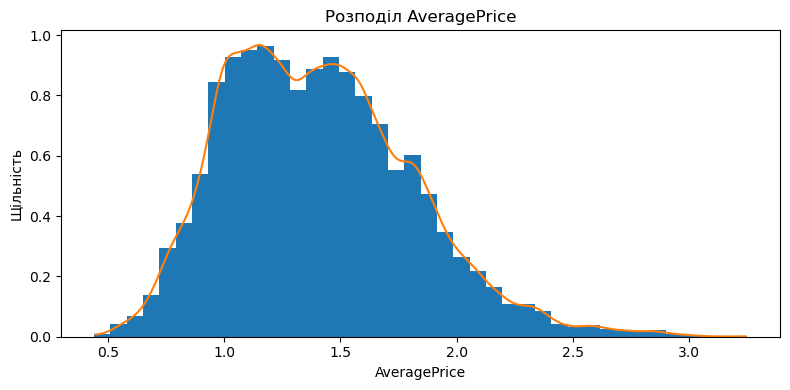

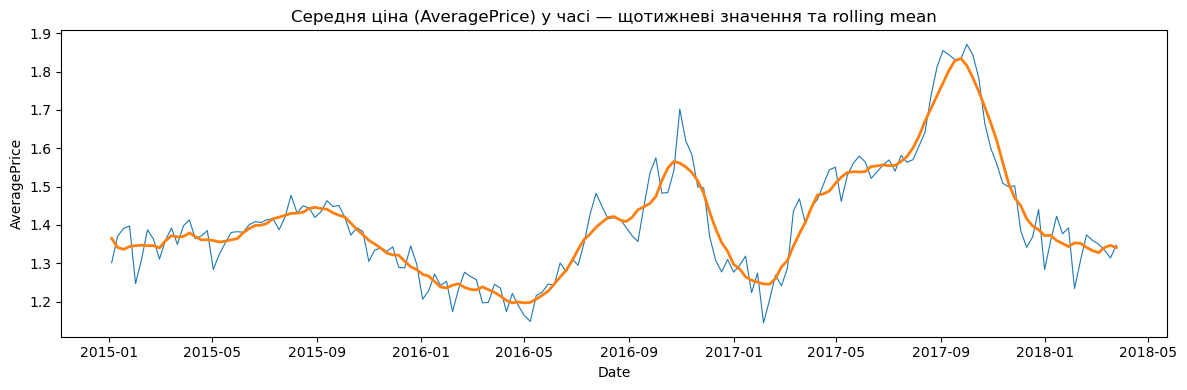

In [5]:

# ------------------------------
# 2.1. Візуалізація даних
# ------------------------------

# Завантажити підготовлений файл 
df = pd.read_csv('data/avocado_prepared.csv', parse_dates=['Date'])

# Ensure Date and month
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
if 'month' not in df.columns and 'Date' in df.columns:
    df['month'] = df['Date'].dt.month

# Prepare type labels
types_sorted = sorted(df['type'].dropna().unique()) if 'type' in df.columns else []
labels = {t: str(t) for t in types_sorted}



In [6]:
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Ensure 'month' exists (якщо раніше не створювали)
if 'month' not in df.columns and 'Date' in df.columns:
    df['month'] = df['Date'].dt.month

# --- Define labels: either map values to prettier names or default to string(value) ---
# Example: автоматичне створення мапи з тим самим текстом (можете вручну змінити)
types_sorted = sorted(df['type'].dropna().unique())
labels = {t: str(t) for t in types_sorted}
# Якщо у Вас є конкретні підписи, зробіть так:
# labels = {'conventional': 'Conventional', 'organic': 'Organic', ...}

# ---------- Histograms + KDE-approx ----------
plt.figure(figsize=(8,4))
for t in types_sorted:
    s = df[df['type'] == t]['AveragePrice'].dropna()
    if s.empty:
        continue
    plt.hist(s, bins=40, density=True, alpha=0.4, label=labels.get(t, str(t)))

# simple smoothed density lines using gaussian filter
for t in types_sorted:
    s = df[df['type'] == t]['AveragePrice'].dropna()
    if s.empty:
        continue
    vals, bins = np.histogram(s, bins=200, density=True)
    centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(centers, gaussian_filter1d(vals, sigma=3), linewidth=1.5)
plt.legend()
plt.title('Histogram / KDE approximation by type')
plt.tight_layout()

# ---------- Time series of AveragePrice by type ----------
plt.figure(figsize=(12,4))
for t in types_sorted:
    # ensure Date exists and drop NaT
    if 'Date' not in df.columns:
        break
    ser = df[df['type'] == t].dropna(subset=['Date', 'AveragePrice']).groupby('Date')['AveragePrice'].mean()
    if ser.empty:
        continue
    plt.plot(ser.index, ser.values, linewidth=1, label=labels.get(t, str(t)))
plt.legend()
plt.title('Time series of AveragePrice by type (mean per Date)')
plt.tight_layout()

# ---------- Seasonality by month (median + IQR) ----------
if 'month' in df.columns:
    monthly = df.groupby('month')['AveragePrice'].agg(['median','count'])
    q1 = df.groupby('month')['AveragePrice'].quantile(0.25)
    q3 = df.groupby('month')['AveragePrice'].quantile(0.75)
    monthly['q1'] = q1
    monthly['q3'] = q3
    monthly['iqr'] = monthly['q3'] - monthly['q1']

    plt.figure(figsize=(10,4))
    months = monthly.index
    plt.plot(months, monthly['median'], marker='o', label='Median')
    plt.fill_between(months,
                     monthly['q1'],
                     monthly['q3'],
                     alpha=0.25, label='IQR (25%-75%)')
    plt.xticks(range(1,13))
    plt.xlabel('Місяць')
    plt.ylabel('AveragePrice')
    plt.title('Медіана AveragePrice по місяцях з IQR')
    plt.legend()
    plt.tight_layout()

# ---------- Scatter: AveragePrice vs Total Volume (і тренд) ----------
plt.figure(figsize=(7,5))
mask = (~df['Total Volume'].isnull()) & (~df['AveragePrice'].isnull())
# guard for non-positive volumes if using log-scale
mask = mask & (df['Total Volume'] > 0)
if mask.any():
    x = df.loc[mask, 'Total Volume']
    y = df.loc[mask, 'AveragePrice']
    plt.scatter(x, y, s=6, alpha=0.6)
    # regression on log1p(volume)
    z = np.polyfit(np.log1p(x), y, 1)
    xp = np.linspace(x.min(), x.max(), 100)
    plt.plot(xp, np.polyval(z, np.log1p(xp)), linewidth=2)
    plt.xscale('log')
    plt.title('AveragePrice vs Total Volume (scatter + trend)')
    plt.xlabel('Total Volume')
    plt.ylabel('AveragePrice')
    plt.tight_layout()
else:
    plt.text(0.5, 0.5, 'No positive Total Volume data for scatter', ha='center')

# ---------- Mean price by top regions ----------
if 'region' in df.columns:
    top_regions = df['region'].value_counts().nlargest(10).index.tolist()
    mean_by_region = df[df['region'].isin(top_regions)].groupby('region')['AveragePrice'].mean().sort_values()
    if not mean_by_region.empty:
        plt.figure(figsize=(8,5))
        plt.barh(mean_by_region.index, mean_by_region.values)
        plt.xlabel('AveragePrice (mean)')
        plt.title('Середня ціна по топ-10 регіонах')
        plt.tight_layout()

plt.show()

NameError: name 'labels' is not defined

<Figure size 800x400 with 0 Axes>

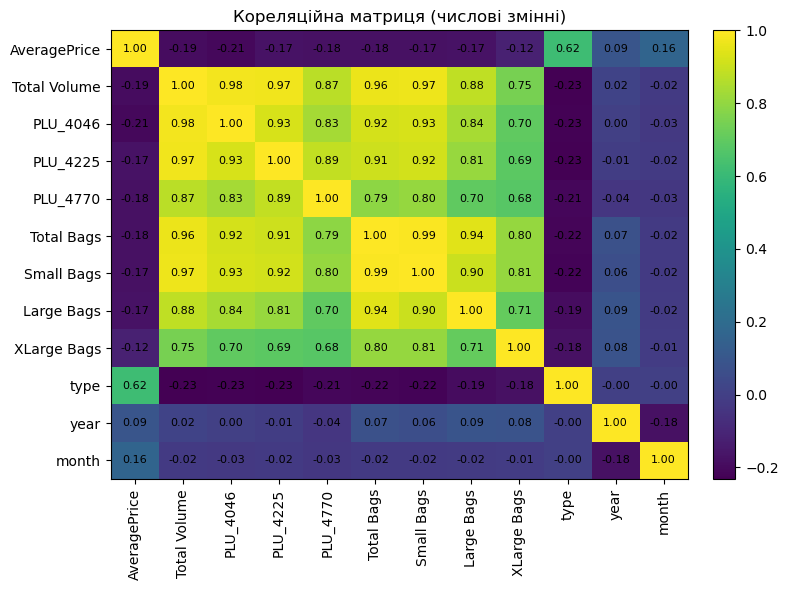

In [ ]:
# Кореляційна матриця 
numeric = df.select_dtypes(include=[np.number]).columns.tolist()
# прибираємо month_sin/month_cos якщо хочеш — тут беремо основні
corr_cols = [c for c in numeric if c in ['AveragePrice','Total Volume','Total Bags','PLU_4046','PLU_4225','PLU_4770','Small Bags','Large Bags','XLarge Bags','type','month','year']]
corr_df = df[corr_cols].corr()
plt.figure(figsize=(8,6))
im = plt.imshow(corr_df, aspect='auto')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr_df.columns)), corr_df.columns, rotation=90)
plt.yticks(range(len(corr_df.index)), corr_df.index)
# підписи значень
for i in range(len(corr_df.index)):
    for j in range(len(corr_df.columns)):
        txt = f"{corr_df.iloc[i,j]:.2f}"
        plt.text(j, i, txt, ha='center', va='center', fontsize=8)
plt.title('Кореляційна матриця (числові змінні)')
plt.tight_layout()
plt.show()

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Вилучити / згорнути сильно-корельовані ознаки
# Виключаємо PLU_* та окремі bag-колонки (залишаємо агрегати Total Volume, Total Bags)
exclude_patterns = ['PLU_', 'Small Bags', 'Large Bags', 'XLarge Bags', 'Small_bags', 'Large_bags', 'XLarge_bags']
cols_to_drop = []
for c in df.columns:
    if any(p in c for p in exclude_patterns):
        cols_to_drop.append(c)
# Перевіримо наявність конкретних PLU колонок
for c in ['PLU_4046','PLU_4225','PLU_4770']:
    if c in df.columns and c not in cols_to_drop:
        cols_to_drop.append(c)

cols_to_drop = [c for c in cols_to_drop if c in df.columns]
if cols_to_drop:
    df = df.drop(columns=cols_to_drop)
    print("Dropped correlated columns:", cols_to_drop)

# Визначити список ознак для моделі (без цілі) 
TARGET = 'AveragePrice'
# Базові числові колонки, які залишаємо автоматично
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Видалити ціль з набору фіч
if TARGET in numeric_cols:
    numeric_cols.remove(TARGET)

# Додати похідні від дати 
date_feats = [c for c in ['year','month','week','dayofweek','month_sin','month_cos'] if c in df.columns]

# Брати числові + type + region + date_feats
features = []
# numeric columns (після видалень)
for c in numeric_cols:
    if c not in date_feats:
        features.append(c)
# гарантуємо присутність date_feats
for c in date_feats:
    if c not in features:
        features.append(c)

# Додаємо категорики
if 'type' in df.columns and 'type' not in features:
    features.append('type')
if 'region' in df.columns and 'region' not in features:
    features.append('region')

print("Використовувані ознаки:", features)

# Розбиття на train / val 
stratify_col = df['type'] if 'type' in df.columns else None
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True,
                                    stratify=stratify_col)

print("Shapes — train:", train_df.shape, " val:", val_df.shape)


Dropped correlated columns: ['PLU_4046', 'PLU_4225', 'PLU_4770', 'Small Bags', 'Large Bags', 'XLarge Bags']
Використовувані ознаки: ['Total Volume', 'Total Bags', 'type', 'year', 'month', 'week', 'dayofweek', 'month_sin', 'month_cos', 'region']
Shapes — train: (14599, 12)  val: (3650, 12)


In [ ]:
#  Frequency encoding для region (на основі train) 
if 'region' in train_df.columns:
    region_counts = train_df['region'].value_counts()
    region_freq = region_counts / len(train_df)   # частка записів у train
    train_df['region_freq'] = train_df['region'].map(region_freq)
    val_df['region_freq'] = val_df['region'].map(region_freq).fillna(0.0)  # невідомі регіони -> 0
    # Додавання до features: переключитись з 'region' на 'region_freq'
    if 'region' in features:
        features = [f for f in features if f != 'region']
    features.append('region_freq')
    print("Added 'region_freq' (frequency encoding).")

# Масштабування числових фіч (StandardScaler) 
# Визначимо числові колонки серед features (крім 'type' яка вже числова 0/1)
num_feats_for_scaler = [c for c in features if train_df[c].dtype in [np.float64, np.int64] and c != 'type']
# Ініціалізація скейлера
scaler = StandardScaler()
# Fit на train
scaler.fit(train_df[num_feats_for_scaler])
# Transform обох наборів
train_df_scaled = train_df.copy()
val_df_scaled = val_df.copy()
train_df_scaled[num_feats_for_scaler] = scaler.transform(train_df[num_feats_for_scaler])
val_df_scaled[num_feats_for_scaler] = scaler.transform(val_df[num_feats_for_scaler])



Added 'region_freq' (frequency encoding).


In [ ]:
# Підготовка X_train, y_train, X_val, y_val 
X_train = train_df_scaled[features].reset_index(drop=True)
y_train = train_df_scaled[TARGET].reset_index(drop=True)
X_val = val_df_scaled[features].reset_index(drop=True)
y_val = val_df_scaled[TARGET].reset_index(drop=True)

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "y_val shape:", y_val.shape)


X_train shape: (14599, 10) y_train shape: (14599,)
X_val shape: (3650, 10) y_val shape: (3650,)
